# PolyaClassifier selecting bagged models

**Purpose**: To select the best combination of constituent PolyaClassifier models to include in the final ensemble.


In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%run -i notebook_setup.py

## IMPORTS AND SETUP

In [4]:
import paper_utilities
from paper_utilities import models

from functools import reduce


In [5]:
PROJECT   = "/projects/b1080/eks/polyadenylation/yeast"
OUTDIR    = os.path.join(PROJECT, 'manuscript', 'analysis', 'polyaclassifier_model_bagging_selection')
RESOURCES = os.path.join(os.path.dirname(OUTDIR), 'resources')
os.makedirs(OUTDIR, exist_ok = True)


In [6]:
boxplot_format = {
    'boxprops'     : {'edgecolor' : 'black', 'linewidth' : 0.5},
    'medianprops'  : {'color' : 'black', 'linewidth' : 0.5},
    'whiskerprops' : {'color' : 'black', 'linewidth' : 0.5},
    'capprops'     : {'color' : 'black', 'linewidth' : 0.5},
    'flierprops'   : {'color' : 'black'},
    'showfliers'   : False
}

barplot_format = {
    'color'     : 'lightgray',
    'edgecolor' : 'black',
    'linewidth' : 0.5
}

## HELPER FUNCTIONS

In [7]:
def compare_configuration(row, config):
    return all([(row[var] == config[var]) for var in config.keys()])


In [8]:
def visualize_parameter_deltas(species, output_prefix, data, base_model, test_var, test_val, test_order, measure, replicates = 5, xlab_type = None, rotate_labels = False, ylim = None, ytickint = 0.01, threshold = None, show_data = False):
    
    ## Filter equivalent models with the single parameter varied
    
    constant_vars = [_ for _ in base_model.keys() if (_ != test_var)]
    
    cond_mat = np.zeros((len(data), len(constant_vars)))
    
    for i,v in enumerate(constant_vars):
        cond_mat[:,i] = (data[v] == base_model[v])
        
    cond = np.all(cond_mat, axis = 1)
    dt = data.loc[cond & (data[test_var].isin(test_order))].copy()
    
    if (xlab_type is not None):
        dt[test_var] = dt[test_var].astype(xlab_type)
    
    ## Confirm that all replicates were successfully included
    
    if (replicates is not None):

        if not (dt.groupby(test_var).size() == replicates).all():
            raise ValueError("Incorrect number of replicates found for test parameters:" + str(dt.groupby(test_var).size()))

        if not (dt.groupby([test_var,'negative_seed']).size() == 1).all():
            raise ValueError("More than one model found per parameter+negative seed combination:" + str(dt.groupby([test_var,'negative_seed']).size()))

    ## Visualize change in the area under the receiver-operating characteristic curve
    
    nlevels = dt[test_var].nunique()
    norder = test_order if (test_order is not None) else sorted(dt[test_var].unique().tolist())
    
    fig,ax = plt.subplots(1,1, figsize = (0.3+(0.15*nlevels),1.5))
    
    dt_diff = dt.merge(dt.pivot(index = 'category', columns = 'iteration', values = 'classification_AUROC').loc[norder].shift(1).mean(axis = 1).reset_index(name = 'previous_mean'))
    dt_diff['delta_AUROC'] = dt_diff['classification_AUROC'] - dt_diff['previous_mean']
    dt_diff['highlight'] = (dt_diff[test_var] == test_val)
    
    sns.barplot(data = dt_diff, x = test_var, y = 'delta_AUROC', order = norder, 
                hue = 'highlight', palette = {False: 'lightgray', True: 'firebrick'}, 
                dodge = False, ax = ax, **barplot_format)
    
    if (threshold is not None):
        ax.axhline(threshold, color = 'red', linewidth = 0.5, zorder = 2)
        
    if (rotate_labels):
        ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, va = 'top', ha = 'right')
    
    ax.set_xlabel(test_var.replace("_"," ").capitalize())
    ax.set_ylabel("delta AUROC")
    
    ax.set_ylim(ylim)
    ax.yaxis.set_major_locator(MultipleLocator(ytickint))
    
    ax.get_legend().remove()

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    plt.savefig(os.path.join(OUTDIR, f'{output_prefix}.{species}.{test_var}.delta_auroc.svg'), format = 'svg', dpi = 600)
    plt.show()
    
    if (show_data):
        print("Classification AUROC:")
        print(dt_diff.groupby(test_var)['classification_AUROC'].describe()[['mean','std','min','max']].loc[norder])
        print("Delta AUROC:")
        print(dt_diff.groupby(test_var)['delta_AUROC'].describe()[['mean','std','min','max']].loc[norder])
    
    ## Visualize change in the area under the precision-recall curve
    
    fig,ax = plt.subplots(1,1, figsize = (0.3+(0.15*nlevels),1.5))
    
    dt_diff = dt.merge(dt.pivot(index = 'category', columns = 'iteration', values = 'classification_AUPRC').loc[norder].shift(1).mean(axis = 1).reset_index(name = 'previous_mean'))
    dt_diff['delta_AUPRC'] = dt_diff['classification_AUPRC'] - dt_diff['previous_mean']
    dt_diff['highlight'] = (dt_diff[test_var] == test_val)
    
    sns.barplot(data = dt_diff, x = test_var, y = 'delta_AUPRC', order = norder, 
                hue = 'highlight', palette = {False: 'lightgray', True: 'firebrick'}, 
                dodge = False, ax = ax, **barplot_format)
    
    if (threshold is not None):
        ax.axhline(threshold, color = 'red', linewidth = 0.5, zorder = 2)
        
    if (rotate_labels):
        ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, va = 'top', ha = 'right')
    
    ax.set_xlabel(test_var.replace("_"," ").capitalize())
    ax.set_ylabel("delta AUPRC")
    
    ax.set_ylim(ylim)
    ax.yaxis.set_major_locator(MultipleLocator(ytickint))
    
    ax.get_legend().remove()

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    plt.savefig(os.path.join(OUTDIR, f'{output_prefix}.{species}.{test_var}.delta_auprc.svg'), format = 'svg', dpi = 600)
    plt.show()
    
    if (show_data):
        print("Classification AUPRC:")
        print(dt_diff.groupby(test_var)['classification_AUPRC'].describe()[['mean','std','min','max']].loc[norder])
        print("Delta AUPRC:")
        print(dt_diff.groupby(test_var)['delta_AUPRC'].describe()[['mean','std','min','max']].loc[norder])
    
    return


In [9]:
def permute_aggregate_performance(species, models, data_desc, data_seeds, model_category, n_models_to_use, num_iter = 10, random_seed = 12345, verbose = False):
    
    stamps_pool = sorted(models.loc[models['category'] == model_category, 'stamp'].tolist())
    
    stamp_list = []
    stamp_res  = []
    counter = 0
    
    ## Select models to use
    
    for i in tqdm.tqdm(range(num_iter), desc = f'{n_models_to_use} models'):

        while True:

            np.random.seed(random_seed+i)
            selected_stamps = np.random.choice(stamps_pool, n_models_to_use, replace = False)

            if (str(selected_stamps) not in stamp_list):
                break

        if (len(selected_stamps) != n_models_to_use):
            raise ValueError(f"Incorrect number of stamps selected: expected={n_models_to_use}, found={len(selected_stamps)}")

        if (verbose):
            print(f"Using {n_models_to_use} models to average predictions: {selected_stamps}")
        
        ## Calculate aggregated performance metrics
        
        agg_results = concatenate_aggregate_performance(species, models, data_desc, data_seeds, selected_stamps, verbose)
        agg_results['iteration'] = i
        agg_results['category'] = f'{model_category}_{n_models_to_use}models'
        
        stamp_res.append(agg_results)

    return pd.concat(stamp_res, ignore_index = True, sort = False)


In [11]:
def compile_input_data(datapath, data_index, data_type, header = True):
    
    data = []
    
    with open(datapath, mode = 'r') as infile:
        if (header):
            infile.readline()
        for line in infile:
            data.append(data_type(line.rstrip("\n").split("\t")[data_index]))
            
    return data
        

In [12]:
def compile_prediction_dict(datapath, sequence_index, prediction_index, header = True):
    
    predictions = {}
    
    with open(datapath, mode = 'r') as infile:
        if (header):
            infile.readline()
        for line in infile:
            llist = line.rstrip("\n").split("\t")
            predictions[llist[sequence_index]] = float(llist[prediction_index])
            
    return predictions
        

In [13]:
def concatenate_aggregate_performance(species, models, data_desc, data_seeds, models_to_use = [], verbose = False):
    
    results   = {}
    counter   = 0
    
    ## Iterate over input data sets
    
    obs_classes  = []
    pred_classes = []

    for data_seed in data_seeds:
        
        ## Combine predictions
        
        sequences = compile_input_data(os.path.join(RESOURCES, 'polyaclassifier_bagging_test', f"{data_desc}_{data_seed}.polyaclassifier_{models_to_use[0]}.txt"), 9, str)
        reads     = compile_input_data(os.path.join(RESOURCES, 'polyaclassifier_bagging_test', f"{data_desc}_{data_seed}.polyaclassifier_{models_to_use[0]}.txt"), 6, float)
        classes   = (np.asarray(reads) > 0).astype(int)

        predictions = np.zeros((len(sequences),len(models_to_use)))

        for i,s in enumerate(models_to_use):
            sdict = compile_prediction_dict(os.path.join(RESOURCES, 'polyaclassifier_bagging_test', f"{data_desc}_{data_seed}.polyaclassifier_{s}.txt"), 9, 12)
            predictions[:,i] = np.asarray([sdict[seq] for seq in sequences])

        predictions = np.mean(predictions, axis = 1)
    
        ## Quality length of data lists
        
        if (len(list(set([len(sequences), len(reads), len(classes), len(predictions)]))) > 1):
            raise ValueError()

        ## Recalculate AUROC and AUPRC using mean predictions
    
        obs_classes.append(classes)
        pred_classes.append(predictions)
        
    obs_classes  = list(itertools.chain.from_iterable(obs_classes))
    pred_classes = list(itertools.chain.from_iterable(pred_classes))

    fpr, tpr, thresholds = roc_curve(obs_classes, pred_classes)
    auroc = auc(fpr, tpr)

    prec, rec, thresholds = precision_recall_curve(obs_classes, pred_classes)
    auprc = auc(rec, prec)

    results[counter] = {'model_stamps': models_to_use, 'negative_seed': data_seed, 'classification_AUROC': auroc, 'classification_AUPRC': auprc}
    counter += 1

    return pd.DataFrame.from_dict(results, orient = 'index')


## ANALYSIS

### *S. cerevisiae*

In [14]:
scer_config = {
    'genomic_As'    : 'redistA',
    'architecture'  : 'classification',
    'sequence_size' : 500,
    'conv_units'    : 512,
    'lstm_units'    : 16,
    'conv_shape'    : 12,
    'bin_dropout'   : 0.5,
    'learning_rate' : 0.001,
}


In [15]:
scer_data = pd.read_csv(os.path.join(RESOURCES, 'polyaclassifier_replicate_summary.saccharomyces_cerevisiae.txt'), sep = "\t")
scer_data = scer_data.loc[scer_data.apply(lambda row : compare_configuration(row, scer_config), axis = 1) & (scer_data['modeltype'] == 'special_bagging')]
scer_data['category'] = 'bagging'
print(scer_data.shape)


(20, 22)


#### Calculate the performance of the "bagged" model using the average of multiple predictions

In [16]:
bagging_stamps = ['12345',  '24690',  '37035',  '49380',  '61725',  '74070',  '86415',  '98760',  '111105', '123450', 
                  '135795', '148140', '160485', '172830', '185175', '197520', '209865', '222210', '234555', '246900']

scer_bag1_res  = permute_aggregate_performance('saccharomyces_cerevisiae', scer_data, 'scer_bagging_val_data', bagging_stamps, 'bagging',  1, 10, 12345)
scer_bag2_res  = permute_aggregate_performance('saccharomyces_cerevisiae', scer_data, 'scer_bagging_val_data', bagging_stamps, 'bagging',  2, 10, 12345)
scer_bag3_res  = permute_aggregate_performance('saccharomyces_cerevisiae', scer_data, 'scer_bagging_val_data', bagging_stamps, 'bagging',  3, 10, 12345)
scer_bag4_res  = permute_aggregate_performance('saccharomyces_cerevisiae', scer_data, 'scer_bagging_val_data', bagging_stamps, 'bagging',  4, 10, 12345)
scer_bag5_res  = permute_aggregate_performance('saccharomyces_cerevisiae', scer_data, 'scer_bagging_val_data', bagging_stamps, 'bagging',  5, 10, 12345)
scer_bag6_res  = permute_aggregate_performance('saccharomyces_cerevisiae', scer_data, 'scer_bagging_val_data', bagging_stamps, 'bagging',  6, 10, 12345)
scer_bag7_res  = permute_aggregate_performance('saccharomyces_cerevisiae', scer_data, 'scer_bagging_val_data', bagging_stamps, 'bagging',  7, 10, 12345)
scer_bag8_res  = permute_aggregate_performance('saccharomyces_cerevisiae', scer_data, 'scer_bagging_val_data', bagging_stamps, 'bagging',  8, 10, 12345)
scer_bag9_res  = permute_aggregate_performance('saccharomyces_cerevisiae', scer_data, 'scer_bagging_val_data', bagging_stamps, 'bagging',  9, 10, 12345)
scer_bag10_res = permute_aggregate_performance('saccharomyces_cerevisiae', scer_data, 'scer_bagging_val_data', bagging_stamps, 'bagging', 10, 10, 12345)
scer_bag11_res = permute_aggregate_performance('saccharomyces_cerevisiae', scer_data, 'scer_bagging_val_data', bagging_stamps, 'bagging', 11, 10, 12345)
scer_bag12_res = permute_aggregate_performance('saccharomyces_cerevisiae', scer_data, 'scer_bagging_val_data', bagging_stamps, 'bagging', 12, 10, 12345)
scer_bag13_res = permute_aggregate_performance('saccharomyces_cerevisiae', scer_data, 'scer_bagging_val_data', bagging_stamps, 'bagging', 13, 10, 12345)
scer_bag14_res = permute_aggregate_performance('saccharomyces_cerevisiae', scer_data, 'scer_bagging_val_data', bagging_stamps, 'bagging', 14, 10, 12345)
scer_bag15_res = permute_aggregate_performance('saccharomyces_cerevisiae', scer_data, 'scer_bagging_val_data', bagging_stamps, 'bagging', 15, 10, 12345)
scer_bag16_res = permute_aggregate_performance('saccharomyces_cerevisiae', scer_data, 'scer_bagging_val_data', bagging_stamps, 'bagging', 16, 10, 12345)
scer_bag17_res = permute_aggregate_performance('saccharomyces_cerevisiae', scer_data, 'scer_bagging_val_data', bagging_stamps, 'bagging', 17, 10, 12345)
scer_bag18_res = permute_aggregate_performance('saccharomyces_cerevisiae', scer_data, 'scer_bagging_val_data', bagging_stamps, 'bagging', 18, 10, 12345)
scer_bag19_res = permute_aggregate_performance('saccharomyces_cerevisiae', scer_data, 'scer_bagging_val_data', bagging_stamps, 'bagging', 19, 10, 12345)
scer_bag20_res = permute_aggregate_performance('saccharomyces_cerevisiae', scer_data, 'scer_bagging_val_data', bagging_stamps, 'bagging', 20, 1,  12345)


20 models: 100%|██████████| 1/1 [00:20<00:00, 20.80s/it]


In [17]:
scer_bag_res = pd.concat([scer_bag1_res,  scer_bag2_res,  scer_bag3_res,  scer_bag4_res,  scer_bag5_res, 
                          scer_bag6_res,  scer_bag7_res,  scer_bag8_res,  scer_bag9_res,  scer_bag10_res,
                          scer_bag11_res, scer_bag12_res, scer_bag13_res, scer_bag14_res, scer_bag15_res, 
                          scer_bag16_res, scer_bag17_res, scer_bag18_res, scer_bag19_res, scer_bag20_res,
                         ], ignore_index = True, sort = False)

for k,v in scer_config.items():
    scer_bag_res[k] = v


#### Visualize the improvement in performance metrics for various numbers of bagged models

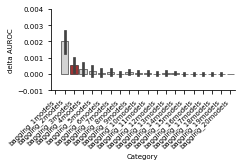

Classification AUROC:
                      mean       std       min       max
category                                                
bagging_1models   0.986225  0.001767  0.983082  0.987830
bagging_2models   0.988257  0.001122  0.985824  0.989231
bagging_3models   0.988832  0.000731  0.987490  0.989612
bagging_4models   0.989142  0.000657  0.987958  0.990008
bagging_5models   0.989336  0.000486  0.988451  0.990131
bagging_6models   0.989428  0.000404  0.988787  0.989937
bagging_7models   0.989533  0.000299  0.989184  0.990013
bagging_8models   0.989527  0.000244  0.989198  0.989953
bagging_9models   0.989668  0.000218  0.989432  0.990070
bagging_10models  0.989711  0.000224  0.989387  0.990126
bagging_11models  0.989760  0.000199  0.989485  0.990050
bagging_12models  0.989778  0.000187  0.989570  0.990105
bagging_13models  0.989819  0.000188  0.989633  0.990164
bagging_14models  0.989868  0.000144  0.989715  0.990096
bagging_15models  0.989864  0.000109  0.989670  0.990025
bagging_1

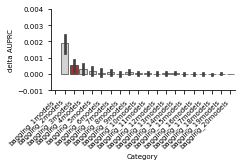

Classification AUPRC:
                      mean       std       min       max
category                                                
bagging_1models   0.987141  0.001460  0.984507  0.988589
bagging_2models   0.989074  0.000922  0.986942  0.989863
bagging_3models   0.989632  0.000570  0.988461  0.990164
bagging_4models   0.989945  0.000548  0.989029  0.990685
bagging_5models   0.990132  0.000408  0.989402  0.990785
bagging_6models   0.990222  0.000322  0.989727  0.990669
bagging_7models   0.990325  0.000247  0.990034  0.990751
bagging_8models   0.990328  0.000191  0.990080  0.990703
bagging_9models   0.990452  0.000172  0.990288  0.990798
bagging_10models  0.990491  0.000174  0.990256  0.990851
bagging_11models  0.990540  0.000153  0.990338  0.990801
bagging_12models  0.990565  0.000152  0.990393  0.990853
bagging_13models  0.990601  0.000155  0.990434  0.990907
bagging_14models  0.990647  0.000118  0.990510  0.990838
bagging_15models  0.990651  0.000091  0.990470  0.990783
bagging_1

In [18]:
visualize_parameter_deltas('saccharomyces_cerevisiae', 'polyaclassifier_bagging_test', scer_bag_res, scer_config, 
                            'category', 'bagging_3models', [f'bagging_{n}models' for n in range(1,21)], 'mean',
                            replicates = None, rotate_labels = True,
                            ylim = (-0.001,0.004), ytickint = 0.001, show_data = True)


#### Examine the stability of bagged model predictions when different models are selected for "bagging"

In [19]:
scer_bag_sample = permute_aggregate_performance('saccharomyces_cerevisiae', scer_data, 'scer_bagging_val_data', bagging_stamps, 'bagging',  3, 50, 12345)


3 models: 100%|██████████| 50/50 [04:17<00:00,  5.15s/it]


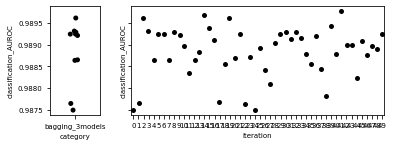

In [20]:
fig,ax = plt.subplots(1,2, figsize = (6,2), sharey = True, gridspec_kw = {'width_ratios': [1,5]})

sns.stripplot(data = scer_bag_res.loc[scer_bag_res['category'] == 'bagging_3models'], x = 'category', y = 'classification_AUROC', color = 'black', ax = ax[0])
sns.stripplot(data = scer_bag_sample, x = 'iteration', y = 'classification_AUROC', color = 'black', ax = ax[1])

plt.show()


In [21]:
scer_best_combo = scer_bag_sample.sort_values('classification_AUROC', ascending = False).iloc[0]

print("AUROC:", scer_best_combo['classification_AUROC'])
print("AUPRC:", scer_best_combo['classification_AUPRC'])
print("Model stamps:", sorted(scer_best_combo['model_stamps'].tolist()))


AUROC: 0.9897669729333323
AUPRC: 0.9904184048271693
Model stamps: ['20240422-094557', '20240422-094624', '20240422-094653']


### *S. pombe*

In [22]:
spom_config = {
    'genomic_As'    : 'redistA',
    'architecture'  : 'classification1',
    'sequence_size' : 500,
    'conv_units'    : 512,
    'lstm_units'    : 16,
    'conv_shape'    : 6,
    'bin_dropout'   : 0.5,
    'learning_rate' : 0.001,
}


In [23]:
spom_data = pd.read_csv(os.path.join(RESOURCES, 'polyaclassifier_replicate_summary.schizosaccharomyces_pombe.txt'), sep = "\t")
spom_data = spom_data.loc[spom_data.apply(lambda row : compare_configuration(row, spom_config), axis = 1) & (spom_data['modeltype'] == 'special_bagging')]
spom_data['category'] = 'bagging'
print(spom_data.shape)


(20, 22)


#### Calculate the performance of the "bagged" model using the average of multiple predictions

In [24]:
bagging_stamps = ['12345',  '24690',  '37035',  '49380',  '61725',  '74070',  '86415',  '98760',  '111105', '123450', 
                  '135795', '148140', '160485', '172830', '185175', '197520', '209865', '222210', '234555', '246900']

spom_bag1_res  = permute_aggregate_performance('schizosaccharomyces_pombe', spom_data, 'spom_bagging_val_data', bagging_stamps, 'bagging',  1, 10, 12345)
spom_bag2_res  = permute_aggregate_performance('schizosaccharomyces_pombe', spom_data, 'spom_bagging_val_data', bagging_stamps, 'bagging',  2, 10, 12345)
spom_bag3_res  = permute_aggregate_performance('schizosaccharomyces_pombe', spom_data, 'spom_bagging_val_data', bagging_stamps, 'bagging',  3, 10, 12345)
spom_bag4_res  = permute_aggregate_performance('schizosaccharomyces_pombe', spom_data, 'spom_bagging_val_data', bagging_stamps, 'bagging',  4, 10, 12345)
spom_bag5_res  = permute_aggregate_performance('schizosaccharomyces_pombe', spom_data, 'spom_bagging_val_data', bagging_stamps, 'bagging',  5, 10, 12345)
spom_bag6_res  = permute_aggregate_performance('schizosaccharomyces_pombe', spom_data, 'spom_bagging_val_data', bagging_stamps, 'bagging',  6, 10, 12345)
spom_bag7_res  = permute_aggregate_performance('schizosaccharomyces_pombe', spom_data, 'spom_bagging_val_data', bagging_stamps, 'bagging',  7, 10, 12345)
spom_bag8_res  = permute_aggregate_performance('schizosaccharomyces_pombe', spom_data, 'spom_bagging_val_data', bagging_stamps, 'bagging',  8, 10, 12345)
spom_bag9_res  = permute_aggregate_performance('schizosaccharomyces_pombe', spom_data, 'spom_bagging_val_data', bagging_stamps, 'bagging',  9, 10, 12345)
spom_bag10_res = permute_aggregate_performance('schizosaccharomyces_pombe', spom_data, 'spom_bagging_val_data', bagging_stamps, 'bagging', 10, 10, 12345)
spom_bag11_res = permute_aggregate_performance('schizosaccharomyces_pombe', spom_data, 'spom_bagging_val_data', bagging_stamps, 'bagging', 11, 10, 12345)
spom_bag12_res = permute_aggregate_performance('schizosaccharomyces_pombe', spom_data, 'spom_bagging_val_data', bagging_stamps, 'bagging', 12, 10, 12345)
spom_bag13_res = permute_aggregate_performance('schizosaccharomyces_pombe', spom_data, 'spom_bagging_val_data', bagging_stamps, 'bagging', 13, 10, 12345)
spom_bag14_res = permute_aggregate_performance('schizosaccharomyces_pombe', spom_data, 'spom_bagging_val_data', bagging_stamps, 'bagging', 14, 10, 12345)
spom_bag15_res = permute_aggregate_performance('schizosaccharomyces_pombe', spom_data, 'spom_bagging_val_data', bagging_stamps, 'bagging', 15, 10, 12345)
spom_bag16_res = permute_aggregate_performance('schizosaccharomyces_pombe', spom_data, 'spom_bagging_val_data', bagging_stamps, 'bagging', 16, 10, 12345)
spom_bag17_res = permute_aggregate_performance('schizosaccharomyces_pombe', spom_data, 'spom_bagging_val_data', bagging_stamps, 'bagging', 17, 10, 12345)
spom_bag18_res = permute_aggregate_performance('schizosaccharomyces_pombe', spom_data, 'spom_bagging_val_data', bagging_stamps, 'bagging', 18, 10, 12345)
spom_bag19_res = permute_aggregate_performance('schizosaccharomyces_pombe', spom_data, 'spom_bagging_val_data', bagging_stamps, 'bagging', 19, 10, 12345)
spom_bag20_res = permute_aggregate_performance('schizosaccharomyces_pombe', spom_data, 'spom_bagging_val_data', bagging_stamps, 'bagging', 20, 1,  12345)


20 models: 100%|██████████| 1/1 [00:04<00:00,  4.91s/it]


In [25]:
spom_bag_res = pd.concat([spom_bag1_res,  spom_bag2_res,  spom_bag3_res,  spom_bag4_res,  spom_bag5_res, 
                          spom_bag6_res,  spom_bag7_res,  spom_bag8_res,  spom_bag9_res,  spom_bag10_res,
                          spom_bag11_res, spom_bag12_res, spom_bag13_res, spom_bag14_res, spom_bag15_res, 
                          spom_bag16_res, spom_bag17_res, spom_bag18_res, spom_bag19_res, spom_bag20_res,
                         ], ignore_index = True, sort = False)

for k,v in spom_config.items():
    spom_bag_res[k] = v


#### Visualize the improvement in performance metrics for various numbers of bagged models

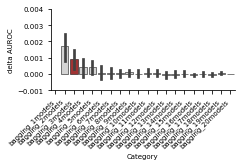

Classification AUROC:
                      mean       std       min       max
category                                                
bagging_1models   0.980751  0.000970  0.978889  0.982562
bagging_2models   0.982488  0.001405  0.979159  0.984047
bagging_3models   0.983438  0.001011  0.981162  0.984849
bagging_4models   0.983841  0.000926  0.981932  0.985126
bagging_5models   0.984246  0.000669  0.982929  0.985276
bagging_6models   0.984317  0.000685  0.983148  0.985333
bagging_7models   0.984383  0.000491  0.983545  0.985191
bagging_8models   0.984426  0.000349  0.983866  0.984795
bagging_9models   0.984536  0.000320  0.983980  0.984914
bagging_10models  0.984568  0.000356  0.984026  0.984984
bagging_11models  0.984661  0.000362  0.984209  0.985156
bagging_12models  0.984721  0.000293  0.984353  0.985205
bagging_13models  0.984647  0.000324  0.984146  0.985119
bagging_14models  0.984618  0.000322  0.984217  0.985042
bagging_15models  0.984626  0.000271  0.984221  0.985050
bagging_1

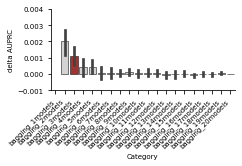

Classification AUPRC:
                      mean       std       min       max
category                                                
bagging_1models   0.980531  0.000811  0.979192  0.981905
bagging_2models   0.982543  0.001308  0.979560  0.984128
bagging_3models   0.983646  0.001000  0.981643  0.985200
bagging_4models   0.984088  0.000913  0.982161  0.985445
bagging_5models   0.984550  0.000676  0.983214  0.985611
bagging_6models   0.984620  0.000708  0.983362  0.985645
bagging_7models   0.984699  0.000539  0.983792  0.985587
bagging_8models   0.984763  0.000359  0.984099  0.985181
bagging_9models   0.984905  0.000368  0.984185  0.985321
bagging_10models  0.984951  0.000382  0.984311  0.985378
bagging_11models  0.985041  0.000370  0.984518  0.985563
bagging_12models  0.985099  0.000308  0.984752  0.985621
bagging_13models  0.985041  0.000344  0.984456  0.985502
bagging_14models  0.985026  0.000327  0.984591  0.985436
bagging_15models  0.985055  0.000289  0.984577  0.985492
bagging_1

In [26]:
visualize_parameter_deltas('schizosaccharomyces_pombe', 'polyaclassifier_bagging_test', spom_bag_res, spom_config, 
                            'category', 'bagging_3models', [f'bagging_{n}models' for n in range(1,21)], 'mean',
                            replicates = None, rotate_labels = True,
                            ylim = (-0.001,0.004), ytickint = 0.001, show_data = True)


#### Examine the stability of bagged model predictions when different models are selected for "bagging"

In [27]:
spom_bag_samples = permute_aggregate_performance('schizosaccharomyces_cerevisiae', spom_data, 'spom_bagging_val_data', bagging_stamps, 'bagging',  3, 50, 12345)


3 models: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it]


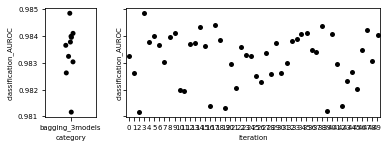

In [28]:
fig,ax = plt.subplots(1,2, figsize = (6,2), sharey = True, gridspec_kw = {'width_ratios': [1,5]})

sns.stripplot(data = spom_bag_res.loc[spom_bag_res['category'] == 'bagging_3models'], x = 'category', y = 'classification_AUROC', color = 'black', ax = ax[0])
sns.stripplot(data = spom_bag_samples, x = 'iteration', y = 'classification_AUROC', color = 'black', ax = ax[1])

plt.show()


In [29]:
spom_best_combo = spom_bag_samples.sort_values('classification_AUROC', ascending = False).iloc[0]

print("AUROC:", spom_best_combo['classification_AUROC'])
print("AUPRC:", spom_best_combo['classification_AUPRC'])
print("Model stamps:", sorted(spom_best_combo['model_stamps'].tolist()))


AUROC: 0.9848485817358208
AUPRC: 0.985199798356565
Model stamps: ['20240422-094802', '20240422-094812', '20240422-094843']


### *A. thaliana*

In [30]:
atha_config = {
    'genomic_As'    : 'redistA',
    'architecture'  : 'classification2',
    'sequence_size' : 500,
    'conv_units'    : 512,
    'lstm_units'    : 16,
    'conv_shape'    : 10,
    'bin_dropout'   : 0.5,
    'learning_rate' : 0.001,
}


In [31]:
atha_data = pd.read_csv(os.path.join(RESOURCES, 'polyaclassifier_replicate_summary.arabidopsis_thaliana.txt'), sep = "\t")
atha_data = atha_data.loc[atha_data.apply(lambda row : compare_configuration(row, atha_config), axis = 1) & (atha_data['modeltype'] == 'special_bagging')]
atha_data['category'] = 'bagging'
print(atha_data.shape)


(20, 22)


#### Calculate the performance of the "bagged" model using the average of multiple predictions

In [32]:
bagging_stamps = ['12345',  '24690',  '37035',  '49380',  '61725',  '74070',  '86415',  '98760',  '111105', '123450', 
                  '135795', '148140', '160485', '172830', '185175', '197520', '209865', '222210', '234555', '246900']

atha_bag1_res  = permute_aggregate_performance('arabidopsis_thaliana', atha_data, 'atha_bagging_val_data', bagging_stamps, 'bagging',  1, 10, 12345)
atha_bag2_res  = permute_aggregate_performance('arabidopsis_thaliana', atha_data, 'atha_bagging_val_data', bagging_stamps, 'bagging',  2, 10, 12345)
atha_bag3_res  = permute_aggregate_performance('arabidopsis_thaliana', atha_data, 'atha_bagging_val_data', bagging_stamps, 'bagging',  3, 10, 12345)
atha_bag4_res  = permute_aggregate_performance('arabidopsis_thaliana', atha_data, 'atha_bagging_val_data', bagging_stamps, 'bagging',  4, 10, 12345)
atha_bag5_res  = permute_aggregate_performance('arabidopsis_thaliana', atha_data, 'atha_bagging_val_data', bagging_stamps, 'bagging',  5, 10, 12345)
atha_bag6_res  = permute_aggregate_performance('arabidopsis_thaliana', atha_data, 'atha_bagging_val_data', bagging_stamps, 'bagging',  6, 10, 12345)
atha_bag7_res  = permute_aggregate_performance('arabidopsis_thaliana', atha_data, 'atha_bagging_val_data', bagging_stamps, 'bagging',  7, 10, 12345)
atha_bag8_res  = permute_aggregate_performance('arabidopsis_thaliana', atha_data, 'atha_bagging_val_data', bagging_stamps, 'bagging',  8, 10, 12345)
atha_bag9_res  = permute_aggregate_performance('arabidopsis_thaliana', atha_data, 'atha_bagging_val_data', bagging_stamps, 'bagging',  9, 10, 12345)
atha_bag10_res = permute_aggregate_performance('arabidopsis_thaliana', atha_data, 'atha_bagging_val_data', bagging_stamps, 'bagging', 10, 10, 12345)
atha_bag11_res = permute_aggregate_performance('arabidopsis_thaliana', atha_data, 'atha_bagging_val_data', bagging_stamps, 'bagging', 11, 10, 12345)
atha_bag12_res = permute_aggregate_performance('arabidopsis_thaliana', atha_data, 'atha_bagging_val_data', bagging_stamps, 'bagging', 12, 10, 12345)
atha_bag13_res = permute_aggregate_performance('arabidopsis_thaliana', atha_data, 'atha_bagging_val_data', bagging_stamps, 'bagging', 13, 10, 12345)
atha_bag14_res = permute_aggregate_performance('arabidopsis_thaliana', atha_data, 'atha_bagging_val_data', bagging_stamps, 'bagging', 14, 10, 12345)
atha_bag15_res = permute_aggregate_performance('arabidopsis_thaliana', atha_data, 'atha_bagging_val_data', bagging_stamps, 'bagging', 15, 10, 12345)
atha_bag16_res = permute_aggregate_performance('arabidopsis_thaliana', atha_data, 'atha_bagging_val_data', bagging_stamps, 'bagging', 16, 10, 12345)
atha_bag17_res = permute_aggregate_performance('arabidopsis_thaliana', atha_data, 'atha_bagging_val_data', bagging_stamps, 'bagging', 17, 10, 12345)
atha_bag18_res = permute_aggregate_performance('arabidopsis_thaliana', atha_data, 'atha_bagging_val_data', bagging_stamps, 'bagging', 18, 10, 12345)
atha_bag19_res = permute_aggregate_performance('arabidopsis_thaliana', atha_data, 'atha_bagging_val_data', bagging_stamps, 'bagging', 19, 10, 12345)
atha_bag20_res = permute_aggregate_performance('arabidopsis_thaliana', atha_data, 'atha_bagging_val_data', bagging_stamps, 'bagging', 20, 1,  12345)


20 models: 100%|██████████| 1/1 [00:30<00:00, 30.54s/it]


In [33]:
atha_bag_res = pd.concat([atha_bag1_res,  atha_bag2_res,  atha_bag3_res,  atha_bag4_res,  atha_bag5_res, 
                          atha_bag6_res,  atha_bag7_res,  atha_bag8_res,  atha_bag9_res,  atha_bag10_res,
                          atha_bag11_res, atha_bag12_res, atha_bag13_res, atha_bag14_res, atha_bag15_res, 
                          atha_bag16_res, atha_bag17_res, atha_bag18_res, atha_bag19_res, atha_bag20_res,
                         ], ignore_index = True, sort = False)

for k,v in atha_config.items():
    atha_bag_res[k] = v


#### Visualize the improvement in performance metrics for various numbers of bagged models

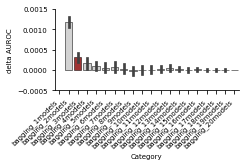

Classification AUROC:
                      mean       std       min       max
category                                                
bagging_1models   0.992822  0.000492  0.992109  0.993355
bagging_2models   0.994001  0.000231  0.993663  0.994345
bagging_3models   0.994315  0.000189  0.993943  0.994644
bagging_4models   0.994484  0.000222  0.994035  0.994797
bagging_5models   0.994585  0.000179  0.994294  0.994858
bagging_6models   0.994642  0.000175  0.994425  0.994949
bagging_7models   0.994714  0.000199  0.994427  0.995031
bagging_8models   0.994742  0.000192  0.994408  0.995074
bagging_9models   0.994723  0.000170  0.994430  0.994963
bagging_10models  0.994726  0.000180  0.994385  0.994985
bagging_11models  0.994734  0.000148  0.994458  0.994923
bagging_12models  0.994768  0.000136  0.994548  0.994944
bagging_13models  0.994810  0.000123  0.994622  0.994970
bagging_14models  0.994828  0.000094  0.994688  0.994963
bagging_15models  0.994825  0.000081  0.994669  0.994930
bagging_1

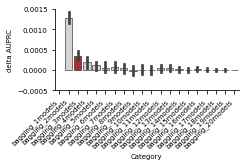

Classification AUPRC:
                      mean       std       min       max
category                                                
bagging_1models   0.992278  0.000500  0.991534  0.992799
bagging_2models   0.993548  0.000243  0.993204  0.993957
bagging_3models   0.993900  0.000194  0.993529  0.994226
bagging_4models   0.994093  0.000245  0.993623  0.994412
bagging_5models   0.994203  0.000178  0.993912  0.994464
bagging_6models   0.994263  0.000194  0.994006  0.994583
bagging_7models   0.994343  0.000216  0.994028  0.994671
bagging_8models   0.994381  0.000210  0.994016  0.994725
bagging_9models   0.994363  0.000183  0.994061  0.994639
bagging_10models  0.994367  0.000189  0.994022  0.994626
bagging_11models  0.994374  0.000154  0.994096  0.994561
bagging_12models  0.994414  0.000146  0.994187  0.994631
bagging_13models  0.994458  0.000134  0.994263  0.994661
bagging_14models  0.994478  0.000106  0.994326  0.994621
bagging_15models  0.994481  0.000091  0.994318  0.994595
bagging_1

In [34]:
visualize_parameter_deltas('arabidopsis_thaliana', 'polyaclassifier_bagging_test', atha_bag_res, atha_config, 
                            'category', 'bagging_3models', [f'bagging_{n}models' for n in range(1,21)], 'mean',
                            replicates = None, rotate_labels = True,
                            ylim = (-0.0005,0.0015), ytickint = 0.0005, show_data = True)



#### Examine the stability of bagged model predictions when different models are selected for "bagging"

In [35]:
atha_bag_samples = permute_aggregate_performance('arabidopsis_thaliana', atha_data, 'atha_bagging_val_data', bagging_stamps, 'bagging',  3, 50, 12345)


3 models: 100%|██████████| 50/50 [05:09<00:00,  6.19s/it]


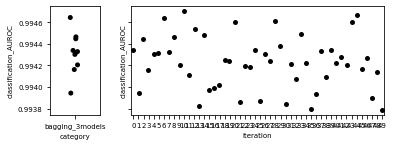

In [36]:
fig,ax = plt.subplots(1,2, figsize = (6,2), sharey = True, gridspec_kw = {'width_ratios': [1,5]})

sns.stripplot(data = atha_bag_res.loc[atha_bag_res['category'] == 'bagging_3models'], x = 'category', y = 'classification_AUROC', color = 'black', ax = ax[0])
sns.stripplot(data = atha_bag_samples, x = 'iteration', y = 'classification_AUROC', color = 'black', ax = ax[1])

plt.show()


In [37]:
atha_best_combo = atha_bag_samples.sort_values('classification_AUROC', ascending = False).iloc[0]

print("AUROC:", atha_best_combo['classification_AUROC'])
print("AUPRC:", atha_best_combo['classification_AUPRC'])
print("Model stamps:", sorted(atha_best_combo['model_stamps'].tolist()))


AUROC: 0.9947016331899119
AUPRC: 0.9943124194276204
Model stamps: ['20240422-094938', '20240422-094958', '20240422-095014']
